## SLI Training Script 
## By Luis A. Urso
## 27-JAN-2023 - version 1
##

In [1]:
import csv
import os
import sys
import numpy as np
import tensorflow as tf
import pydot
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

RANDOM_SEED = 42

# Setup Global Variables

 Define the files path

In [2]:
dataset = 'model/training_data.csv'
model_save_path = 'model/training_classifierf.hdf5'
tflite_save_path = 'model/training_classifier.tflite'

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))


app_path=get_script_path()

Set number of classes to be trained

In [3]:
# Define the number of classes to be trained 

with open('model/labels.csv',encoding='utf-8-sig') as f_labels:
	labels_class = csv.reader(f_labels)
	labels_class = [
		row[0] for row in labels_class
	]



NUM_CLASSES = len(labels_class)

print("Classes to be trained:",NUM_CLASSES)

Classes to be trained: 5


# Dataset Preparation

Dataset loading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
X_dataset.shape

(1579, 42)

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
y_dataset.shape

(1579,)

Split Data Sets into Train and Test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Architecture & Building

FNN Model Arquitecture

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


Model Pre-building Verification 

In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

Model Compilation

In [12]:
# Model compilation

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/10 [==>...........................] - ETA: 3s - loss: 1.7673 - accuracy: 0.2500
Epoch 1: saving model to model\training_classifierf.hdf5
10/10 [==============================] - 1s 17ms/step - loss: 1.7346 - accuracy: 0.2331 - val_loss: 1.6332 - val_accuracy: 0.2608
Epoch 2/1000
 1/10 [==>...........................] - ETA: 0s - loss: 1.6321 - accuracy: 0.2656
Epoch 2: saving model to model\training_classifierf.hdf5
10/10 [==============================] - 0s 5ms/step - loss: 1.6384 - accuracy: 0.2500 - val_loss: 1.5886 - val_accuracy: 0.2608
Epoch 3/1000
 1/10 [==>...........................] - ETA: 0s - loss: 1.6250 - accuracy: 0.2266
Epoch 3: saving model to model\training_classifierf.hdf5
10/10 [==============================] - 0s 5ms/step - loss: 1.5903 - accuracy: 0.2863 - val_loss: 1.5499 - val_accuracy: 0.2684
Epoch 4/1000
 1/10 [==>...........................] - ETA: 0s - loss: 1.5567 - accuracy: 0.2891
Epoch 4: saving model to model\training_classifierf.hdf5


# Training Evaluation

In [14]:
# Model evaluation

val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 1ms/step - loss: 0.0669 - accuracy: 1.0000


In [15]:
# Loading the saved model

model = tf.keras.models.load_model(model_save_path)

In [29]:
# Inference Inference

predict_result = model.predict(np.array([X_test[1]]))
print("Test Label:",np.array([y_test[1]]))
print("Squeeze:", np.squeeze(predict_result)) # make it a single dimention
print("Predicted: ",np.argmax(np.squeeze(predict_result))) # get the index of the max element of the array

1/1 [==============================] - 0s 14ms/step
Test Label: [3]
Squeeze: [9.3495822e-07 4.2516200e-05 4.2140265e-03 9.6386558e-01 3.1876996e-02]
Predicted:  3


# Confusion Matrix

13/13 [==============================] - 0s 754us/step


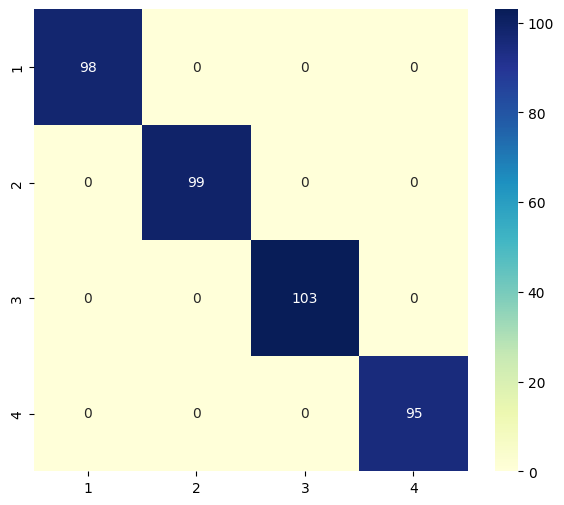

Classification Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        98
           2       1.00      1.00      1.00        99
           3       1.00      1.00      1.00       103
           4       1.00      1.00      1.00        95

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395



In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, cmap="YlGnBu")
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert Model for Tensorflow-Lite

In [31]:
# Save as a model dedicated to inference

model.save(model_save_path, include_optimizer=False)

In [32]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\laurs\AppData\Local\Temp\tmpe5kvlokh\assets


INFO:tensorflow:Assets written to: C:\Users\laurs\AppData\Local\Temp\tmpe5kvlokh\assets


6588

# Inference Test

In [33]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [34]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [35]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [36]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


Check if all labels were considered in the TFLITE converted RNN 

In [44]:
print(np.squeeze(tflite_results))
print("Recorded Labels:",np.argmax(np.squeeze(tflite_results))+1,"of",NUM_CLASSES,"Original Trained Labels:")
print("")
print("*** END OF TRAINIG ***")

[1.2878631e-07 9.7487085e-03 1.0921113e-01 3.6756744e-04 8.8067251e-01]
Recorded Labels: 5 of 5 Original Trained Labels:

*** END OF TRAINIG ***
